# Segmentation notebook

In this tutorial, we will solve a segmentation task with **Batchflow**. The code below is intended to demonstrate the main possibilities of our library.

**Content**:
* [Necessary imports](#imports)
* [Dataset loading and setting the global parameters](#load_dataset)
* [Model configuration](#model)
* [Training pipeline definition](#train_pipeline)
* [Validation pipeline definition](#val_pipeline)
* [Plotting images from the pipeline](#plot)
* [Training stage](#train_stage)
* [Inference stage](#inference)
* [Conclusion](#conclusion)

<a id='imports'></a>
## Necessary imports

In [1]:
import os
import sys
sys.path.insert(0, "../../batchflow")

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from torchinfo import summary

from matplotlib import pyplot as plt
plt.style.use('ggplot')

from batchflow import B, P, R, V, Pipeline, set_gpus
from batchflow.plotter import plot
from batchflow.models.torch import TorchModel
from batchflow.opensets.pascal import PascalSegmentation

import segmentation_models_pytorch as smp

from nbtools import pylint_notebook

_ = set_gpus(1)

`CUDA_VISIBLE_DEVICES` set to "7"


<a id='load_dataset'></a>
## Dataset loading and setting the global parameters

In order to show the solution of the segmentation task, the well-known [**PASCAL VOC 2012**](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset is used. It contains 1464 and 1449 labeled images with 21 classes for training and validation, respectively.\
The Pascal dataset is already in BatchFlow, so you don't need to download it.

In [2]:
dataset = PascalSegmentation()
print('train dataset: ', len(dataset.train))
print('val dataset: ', len(dataset.test))

# Make train dataset bigger
dataset.split(shares=0.9, shuffle=1)
print('New train dataset: ', len(dataset.train))
print('New val dataset: ', len(dataset.test))

train dataset:  1464
val dataset:  1449
New train dataset:  2622
New val dataset:  291


In [3]:
# Set global parameters
IMAGE_SHAPE = (512, 512)

NUM_EPOCHS = 100
FREQUENCY = 10
BATCH_SIZE = 32
MICRO_BATCH_SIZE = 8

NUM_CLASSES = len(dataset.classes)
print('Number of classes: ', NUM_CLASSES)

Number of classes:  21


Let's take a look at the Pascal dataset more closely 

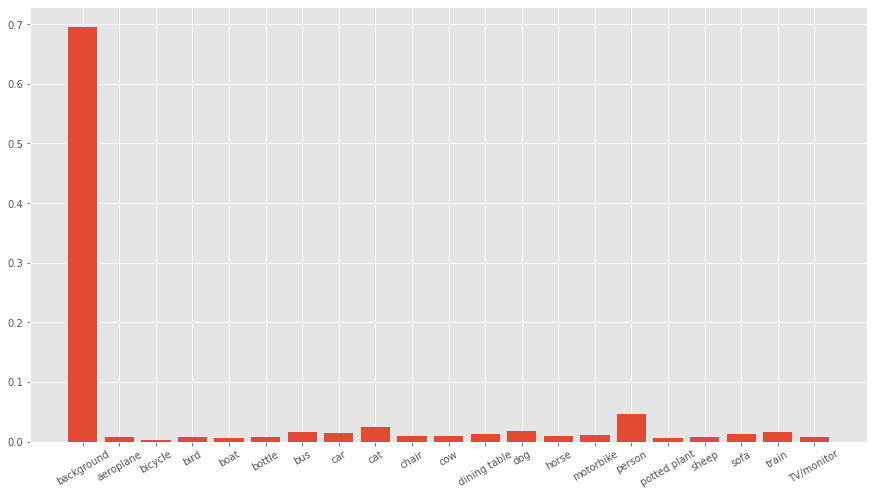

In [4]:
# Count number of unique labels in masks 
batch = dataset.next_batch(batch_size=len(dataset.train), shuffle=True)
unique_labels = np.zeros(256, dtype=np.int)
for mask in batch.labels:
    mask = np.array(mask)
    labels, counts = np.unique(mask, return_counts=True)
    unique_labels[labels] += counts
unique_labels = unique_labels / unique_labels.sum()
nonzero_labels = unique_labels.nonzero()
unique_labels = unique_labels[nonzero_labels]

# Plot barplot without label 255 
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(nonzero_labels[0][:-1], unique_labels[:-1])
ax.set_xticks(np.arange(21))
ax.set_xticklabels(dataset.classes, rotation=30)
plt.show()

You could notice that the masks contain label 255. It's a void label used for border regions and also to mask difficult objects. We will replace this label later. 

Also, there is a high background imbalance. We tried to address this problem with **cross entropy loss with weights** or **dice loss** but the results only got worse.

<a id='model'></a>
## Model configuration

At first, we have to choose the model for our task. In the current tutorial, we will use the **DeepLab** model with a pretrained encoder on the ImageNet dataset from the [repository](https://github.com/qubvel/segmentation_models.pytorch), and we will simply add it to the model config along with other necessary parameters such as optimizer, loss function, etc. 
Alternatively, one can create the DeepLab model or another model via the **model config** like in our previous [tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/00_project_from_scratch.ipynb).

We will construct the model and the training pipeline by using the tricks from the training protocol from the [DeepLab V3 article](https://arxiv.org/abs/1706.05587):
* We use **resizing images to (512, 512)**. However, due to the GPU capacity, we have to apply the **'microbatch'** technique in order to handle so 'big' images. We set the parameter **'microbatch'** in the model config below, it allows one to make chunks of the original batch (microbatches), accumulate their gradients and then make a gradient descent step. 
* We use **'poly'** learning rate decay.
* We use data augmentation by **randomly scaling** images and **randomly left-right flipping**.

In [5]:
deeplab = smp.DeepLabV3(
              encoder_name='resnet50',
              encoder_depth=5,
              encoder_weights='imagenet',
              decoder_channels=256,
              in_channels=3,
              classes=NUM_CLASSES      
)

In [6]:
# We can look at out model architecture and number of trainanble parameters using the torchinfo.summary 
summary(input_size=(1, 3, 256, 256), model=deeplab)

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [1, 21, 256, 256]         --
├─ResNetEncoder: 1-1                               [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                                 [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                   [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                              [1, 64, 64, 64]           --
│    └─Sequential: 2-5                             [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                        [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                        [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                             [1, 512, 32, 32]          --
│    │    └─Bottlen

In [7]:
# The model config 
config = {
    'inputs_shapes': (3, *IMAGE_SHAPE),
    'model': deeplab,
    'device': 'cuda:0',
    'loss': 'ce',
    'optimizer': {'name': 'Adam', 'lr': 1e-4},
    'decay': {
        'name': 'lambda',
        'lr_lambda': lambda epoch: (1.0 - epoch / (NUM_EPOCHS // 10)) ** 0.9,
        'frequency': len(dataset.train) // BATCH_SIZE * 10
    }, # decrease lr every 10th epoch
    'microbatch': MICRO_BATCH_SIZE
}

<a id='train_pipeline'></a>
## Training pipeline definition 

After the model setting, we have to define a training procedure. We will use it as a sequence of **pipelines**. You can find more information about **Batchflow pipelines** in the [pipeline tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/02_pipeline_operations.ipynb).

In [8]:
def unsqueeze_batch(batch):
    """ Unsqueeze the labels images in order to pass them into the dice loss function. """
    batch.train_labels = batch.train_labels[:, None, :, :]
    return batch

def replace_void_label(batch):
    """ Replace label 255 with 0. """
    batch.train_labels[batch.train_labels == 255] = 0
    return batch

In [9]:
load_pipeline = (
    Pipeline()
    .resize(size=IMAGE_SHAPE, src='images', dst='images')
    .resize(size=IMAGE_SHAPE, src='labels', dst='train_labels')
    .to_array(channels='first', src='images', dst='images', dtype=np.float32)
    .to_array(channels=None, src='train_labels', dst='train_labels', dtype=np.float32) 
    .replace_void_label(B())
    .multiply(multiplier=1/255, src='images')
)

augmentations_pipeline = (
    Pipeline()
    .scale(factor=P(R([1.2, 1.4, 1.6])), src=['images', 'labels'],
           dst=['images', 'labels'], preserve_shape=True, p=0.5) 
    .flip(mode='lr', src=['images', 'labels'],
          dst=['images', 'labels'], p=0.5)
)

train_model_pipeline = (
    Pipeline()
    .init_model('model', model_class=TorchModel, mode='dynamic', config=config)
    .init_variable('train_loss', [])
    .train_model('model', inputs=B('images'), targets=B('train_labels'),
                 outputs='loss', save_to=V('train_loss', mode='a'))
)

images_pipeline = (augmentations_pipeline + load_pipeline) << dataset.train
main_pipeline = (
    augmentations_pipeline + \
    load_pipeline + \
    train_model_pipeline
) << dataset.train

You can see that our training pipeline consists of the following parts:
* **load_pipeline** - resizes images and makes other preprocessing stuff
* **augmentations_pipeline** - adds augmentations
* **train_model_pipeline** - initializes our model and other variables and trains the model

We also use **images_pipeline** to plot the images from the train dataset.

The letters-shortcuts such as **B**, **V**, etc. are [named expressions](https://analysiscenter.github.io/batchflow/intro/named_expr.html) which allow addressing data only when the pipeline is run.

<a id='plot'></a>
## Plotting images from the pipeline

Now that we have constructed our training pipeline, we can look at the images:

In [10]:
num_images = 4
batch = images_pipeline.next_batch(num_images, shuffle=True)
images = batch.images.transpose((0, 2, 3, 1))
masks = batch.train_labels
print(images.shape)

(4, 512, 512, 3)


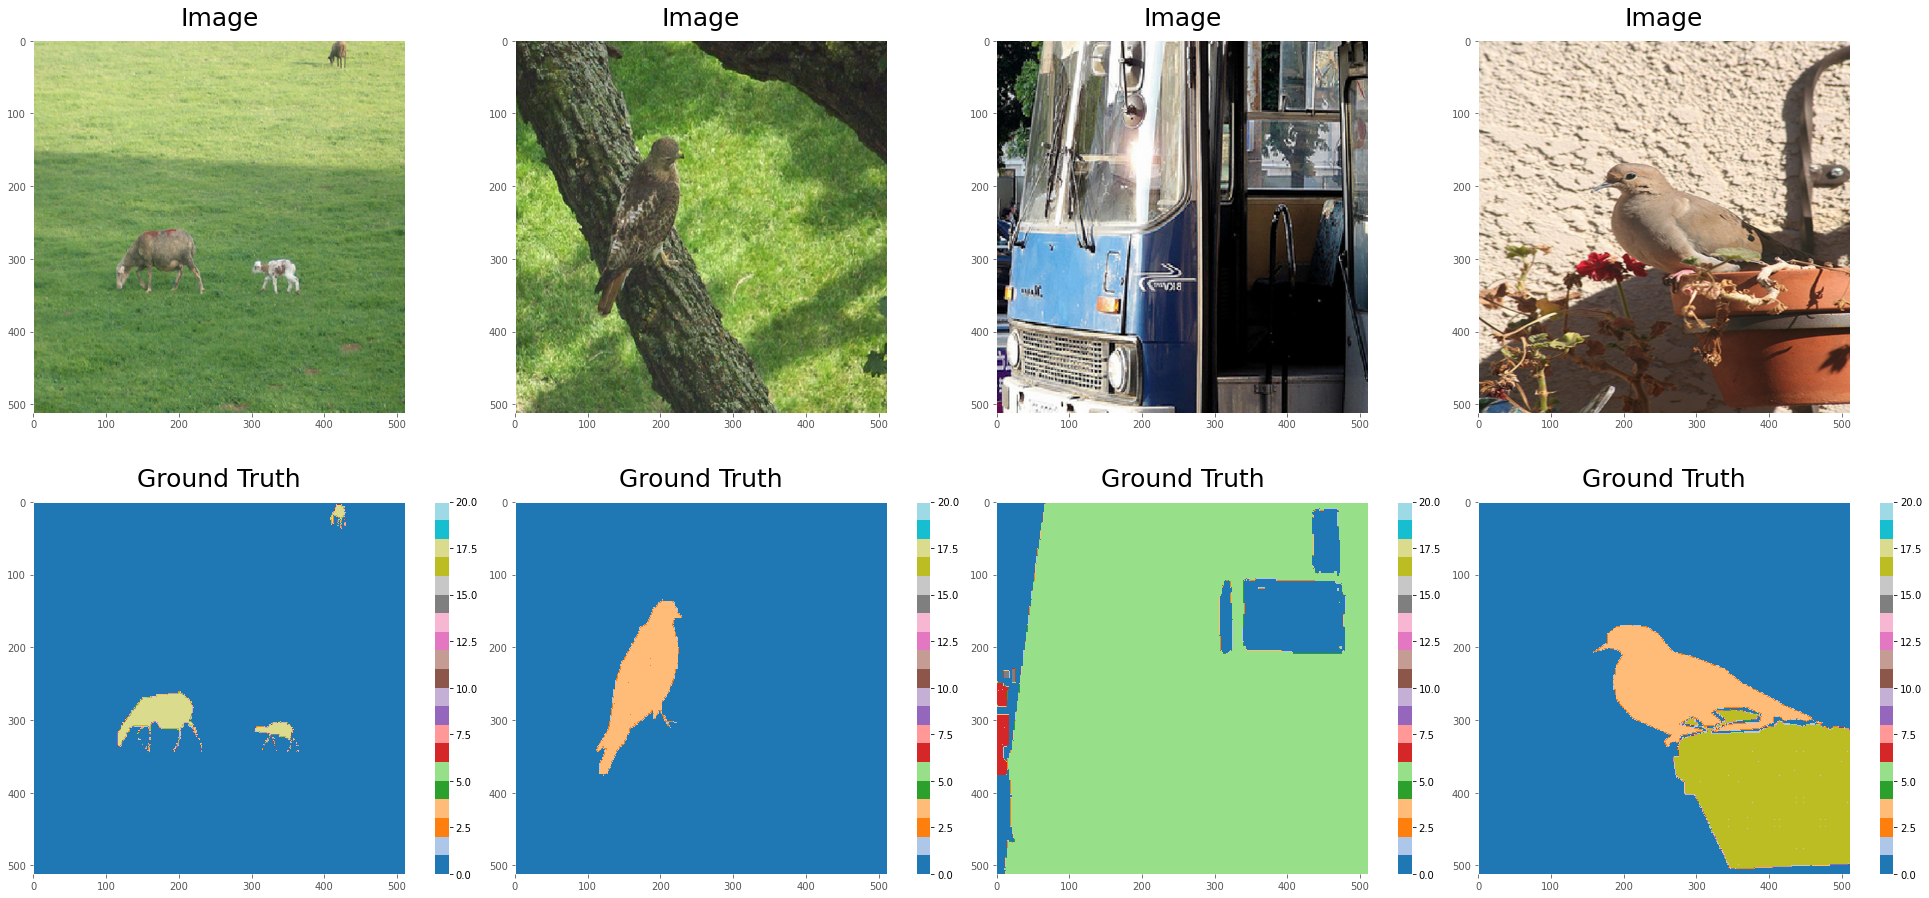

In [11]:
num_images = 4
images_list = [images[i] for i in range(num_images)]
masks_list = [masks[i] for i in range(num_images)]
    
plot(images_list + masks_list,
     title=['Image'] * num_images + ['Ground Truth'] * num_images,
     combine='separate',
     cmap='tab20',
     ncols=num_images,
     nrows=2,
     colorbar=[False] * num_images + [True] * num_images,
     vmin=0, 
     vmax=20)

<a id='val_pipeline'></a>
## Validation pipeline definition 

Before the training stage, we need firstly to set the validation pipeline in order to control the quality of the training: 

In [12]:
metrics_pipeline = (
     Pipeline()
    .import_model('model', main_pipeline)
    .init_variable('metrics')
    .init_variable('predicted_masks')
    .init_variable('val_loss', [])
    .predict_model('model',
                   inputs=B('images'),
                   targets=B('train_labels'),
                   outputs=['predictions', 'loss'],
                   save_to=[B('predicted_masks', mode='w'), V('val_loss', mode='a')]
                  )
    .gather_metrics('segmentation',
                    targets=B('train_labels'),
                    predictions=B('predicted_masks'),
                    fmt='logits',
                    num_classes=NUM_CLASSES,
                    axis=1, 
                    save_to=V('metrics', mode='u')
                    )
)

val_pipeline = (load_pipeline + metrics_pipeline) << dataset.test

The validation pipeline imports the model from the training pipeline and defines the metrics counting via the **gather_metrics** method. Under the hood, this method computes the confusion matrix and allows one to evaluate the wanted metrics, e.g. **accuracy** or **Mean Intersection Over Union (mIoU)**.

<a id='train_stage'></a>
## Training stage

In our training loop, we will use `Notifier` in order to track the training and validation losses at each iteration. We can pass **notifier config** with wanted variables as arguments of the `run` method of our training pipeline.

In addition, `Notifier` allows one to get the resource utilization information about **GPU/CPU** memory. You can find more about **notifier** in the tracking [tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/07_tracking.ipynb).

So, let the training begin!

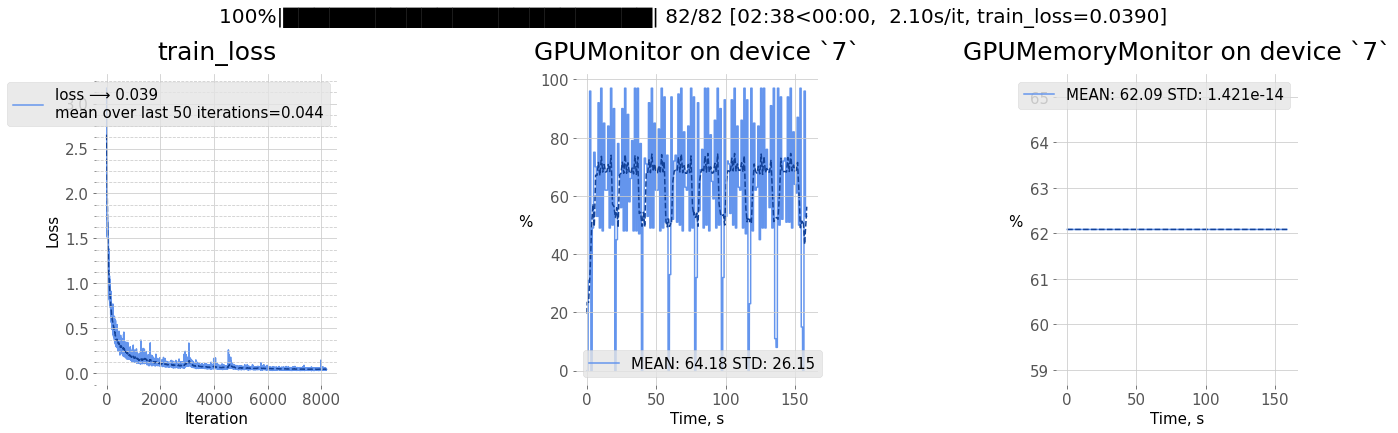

100%|█████████████████████████████████████████████| 9/9 [00:20<00:00,  2.30s/it]


In [13]:
path = 'logs/deeplab_pretrained_change'
if not os.path.exists(path):
    os.mkdir(path)
    
val_loss_history = [np.nan] 
metrics_history = []
min_val_loss = np.inf 
train_loss_history = [np.nan]

train_notifier = {
    'bar': 'n',
    'frequency': FREQUENCY,
    'graphs': [
        {'source': 'train_loss'},
        {'source': 'gpu'},
        {'source': 'gpu_memory'},
    ],
    'savepath': os.path.join(path, 'notifier')
}

for _ in range(NUM_EPOCHS):
    main_pipeline.run(batch_size=BATCH_SIZE, n_epochs=1, shuffle=True, notifier=train_notifier)
    train_loss = main_pipeline.v('train_loss')[-len(dataset.train) // BATCH_SIZE:] 
    train_loss_history.append(np.mean(train_loss))
    
    val_pipeline.run(batch_size=BATCH_SIZE, drop_last=True, bar='t')
    iou = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass='macro')
    metrics_history.append(iou)
    val_loss = val_pipeline.v('val_loss')[-len(dataset.test) // BATCH_SIZE:]
    val_loss_value = np.mean(val_loss)
    val_loss_history.append(val_loss_value)
    
    if val_loss_value < min_val_loss:
        main_pipeline.save_model_now('model', path='deeplab_pretrained_change_final.torch')
        min_val_loss = val_loss_value 

We can also look at the train/val loss, learning rate and metrics after the training:

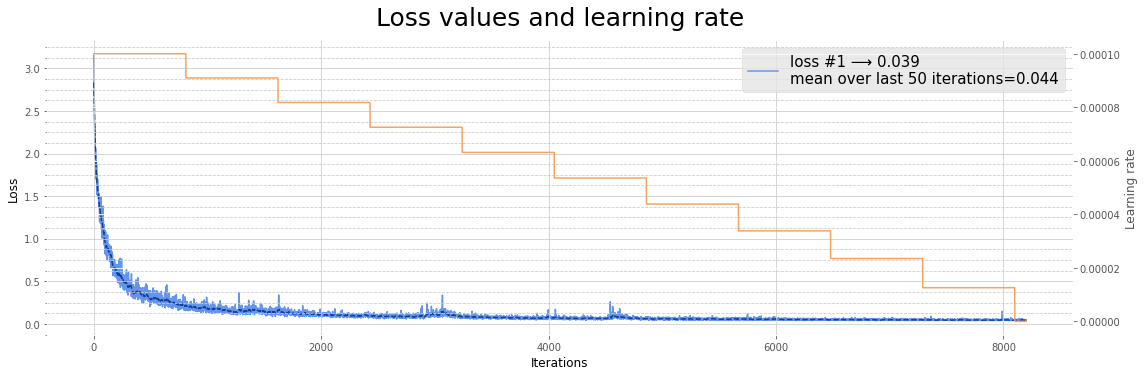

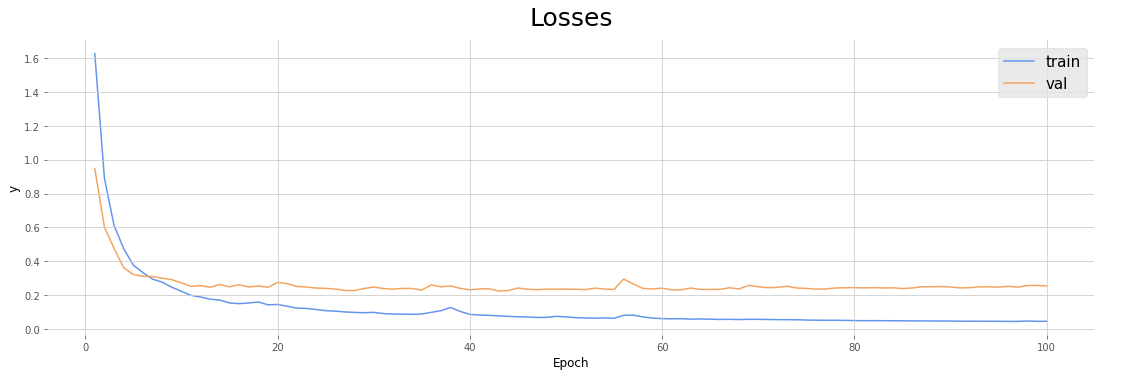

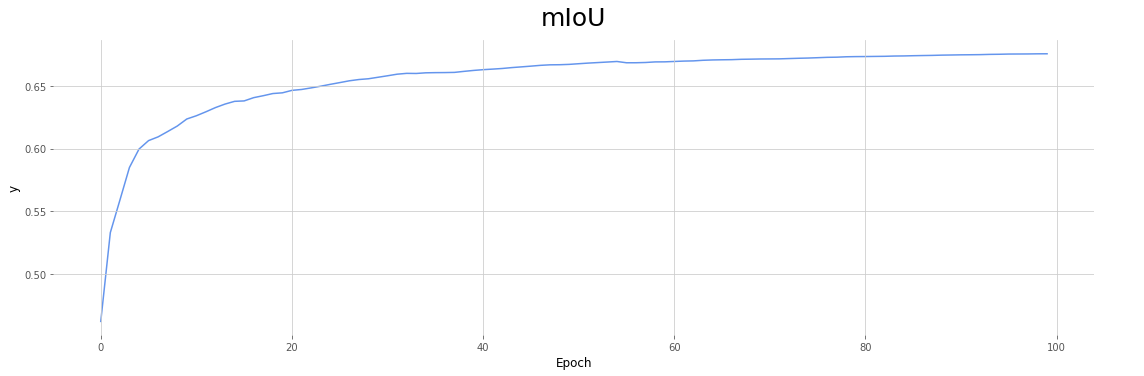

In [14]:
main_pipeline.model.plot_loss()
plot([train_loss_history, val_loss_history], mode='curve', xlabel='Epoch', label=['train', 'val'], title='Losses')
plot(metrics_history, mode='curve', xlabel='Epoch', title='mIoU')

<a id='inference'></a>
## Inference stage

At this stage, we will assess the quality of our model using the **mIoU**:

In [15]:
val_pipeline.run(batch_size=BATCH_SIZE, drop_last=False, bar='t')

IoU_micro = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass='micro')
IoU_macro = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass='macro')
IoU_per_class = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass=None)

100%|███████████████████████████████████████████| 10/10 [00:52<00:00,  5.25s/it]


In [16]:
print(f'Micro mIoU: {IoU_micro:.3f}')
print(f'Macro mIoU: {IoU_macro:.3f}\n')
print('Per class mIoU: ')
for class_iou in zip(np.round(IoU_per_class, 3), dataset.classes):
    print(class_iou)

Micro mIoU: 0.876
Macro mIoU: 0.676

Per class mIoU: 
(0.913, 'background')
(0.564, 'aeroplane')
(0.218, 'bicycle')
(0.592, 'bird')
(0.44, 'boat')
(0.197, 'bottle')
(0.52, 'bus')
(0.528, 'car')
(0.652, 'cat')
(0.1, 'chair')
(0.483, 'cow')
(0.23, 'dining table')
(0.58, 'dog')
(0.577, 'horse')
(0.454, 'motorbike')
(0.496, 'person')
(0.249, 'potted plant')
(0.404, 'sheep')
(0.201, 'sofa')
(0.487, 'train')
(0.385, 'TV/monitor')


Due to the background imbalance, we obtained the high **micro mIoU**, but if we look at the **per class mIoU**, we will see that background contributes the most in this metric. Therefore, the **macro mIoU** will be used.

However, if we solve a segmentation task, the most effective way to evaluate the quality of our model is to see the generated masks with your own eyes:  

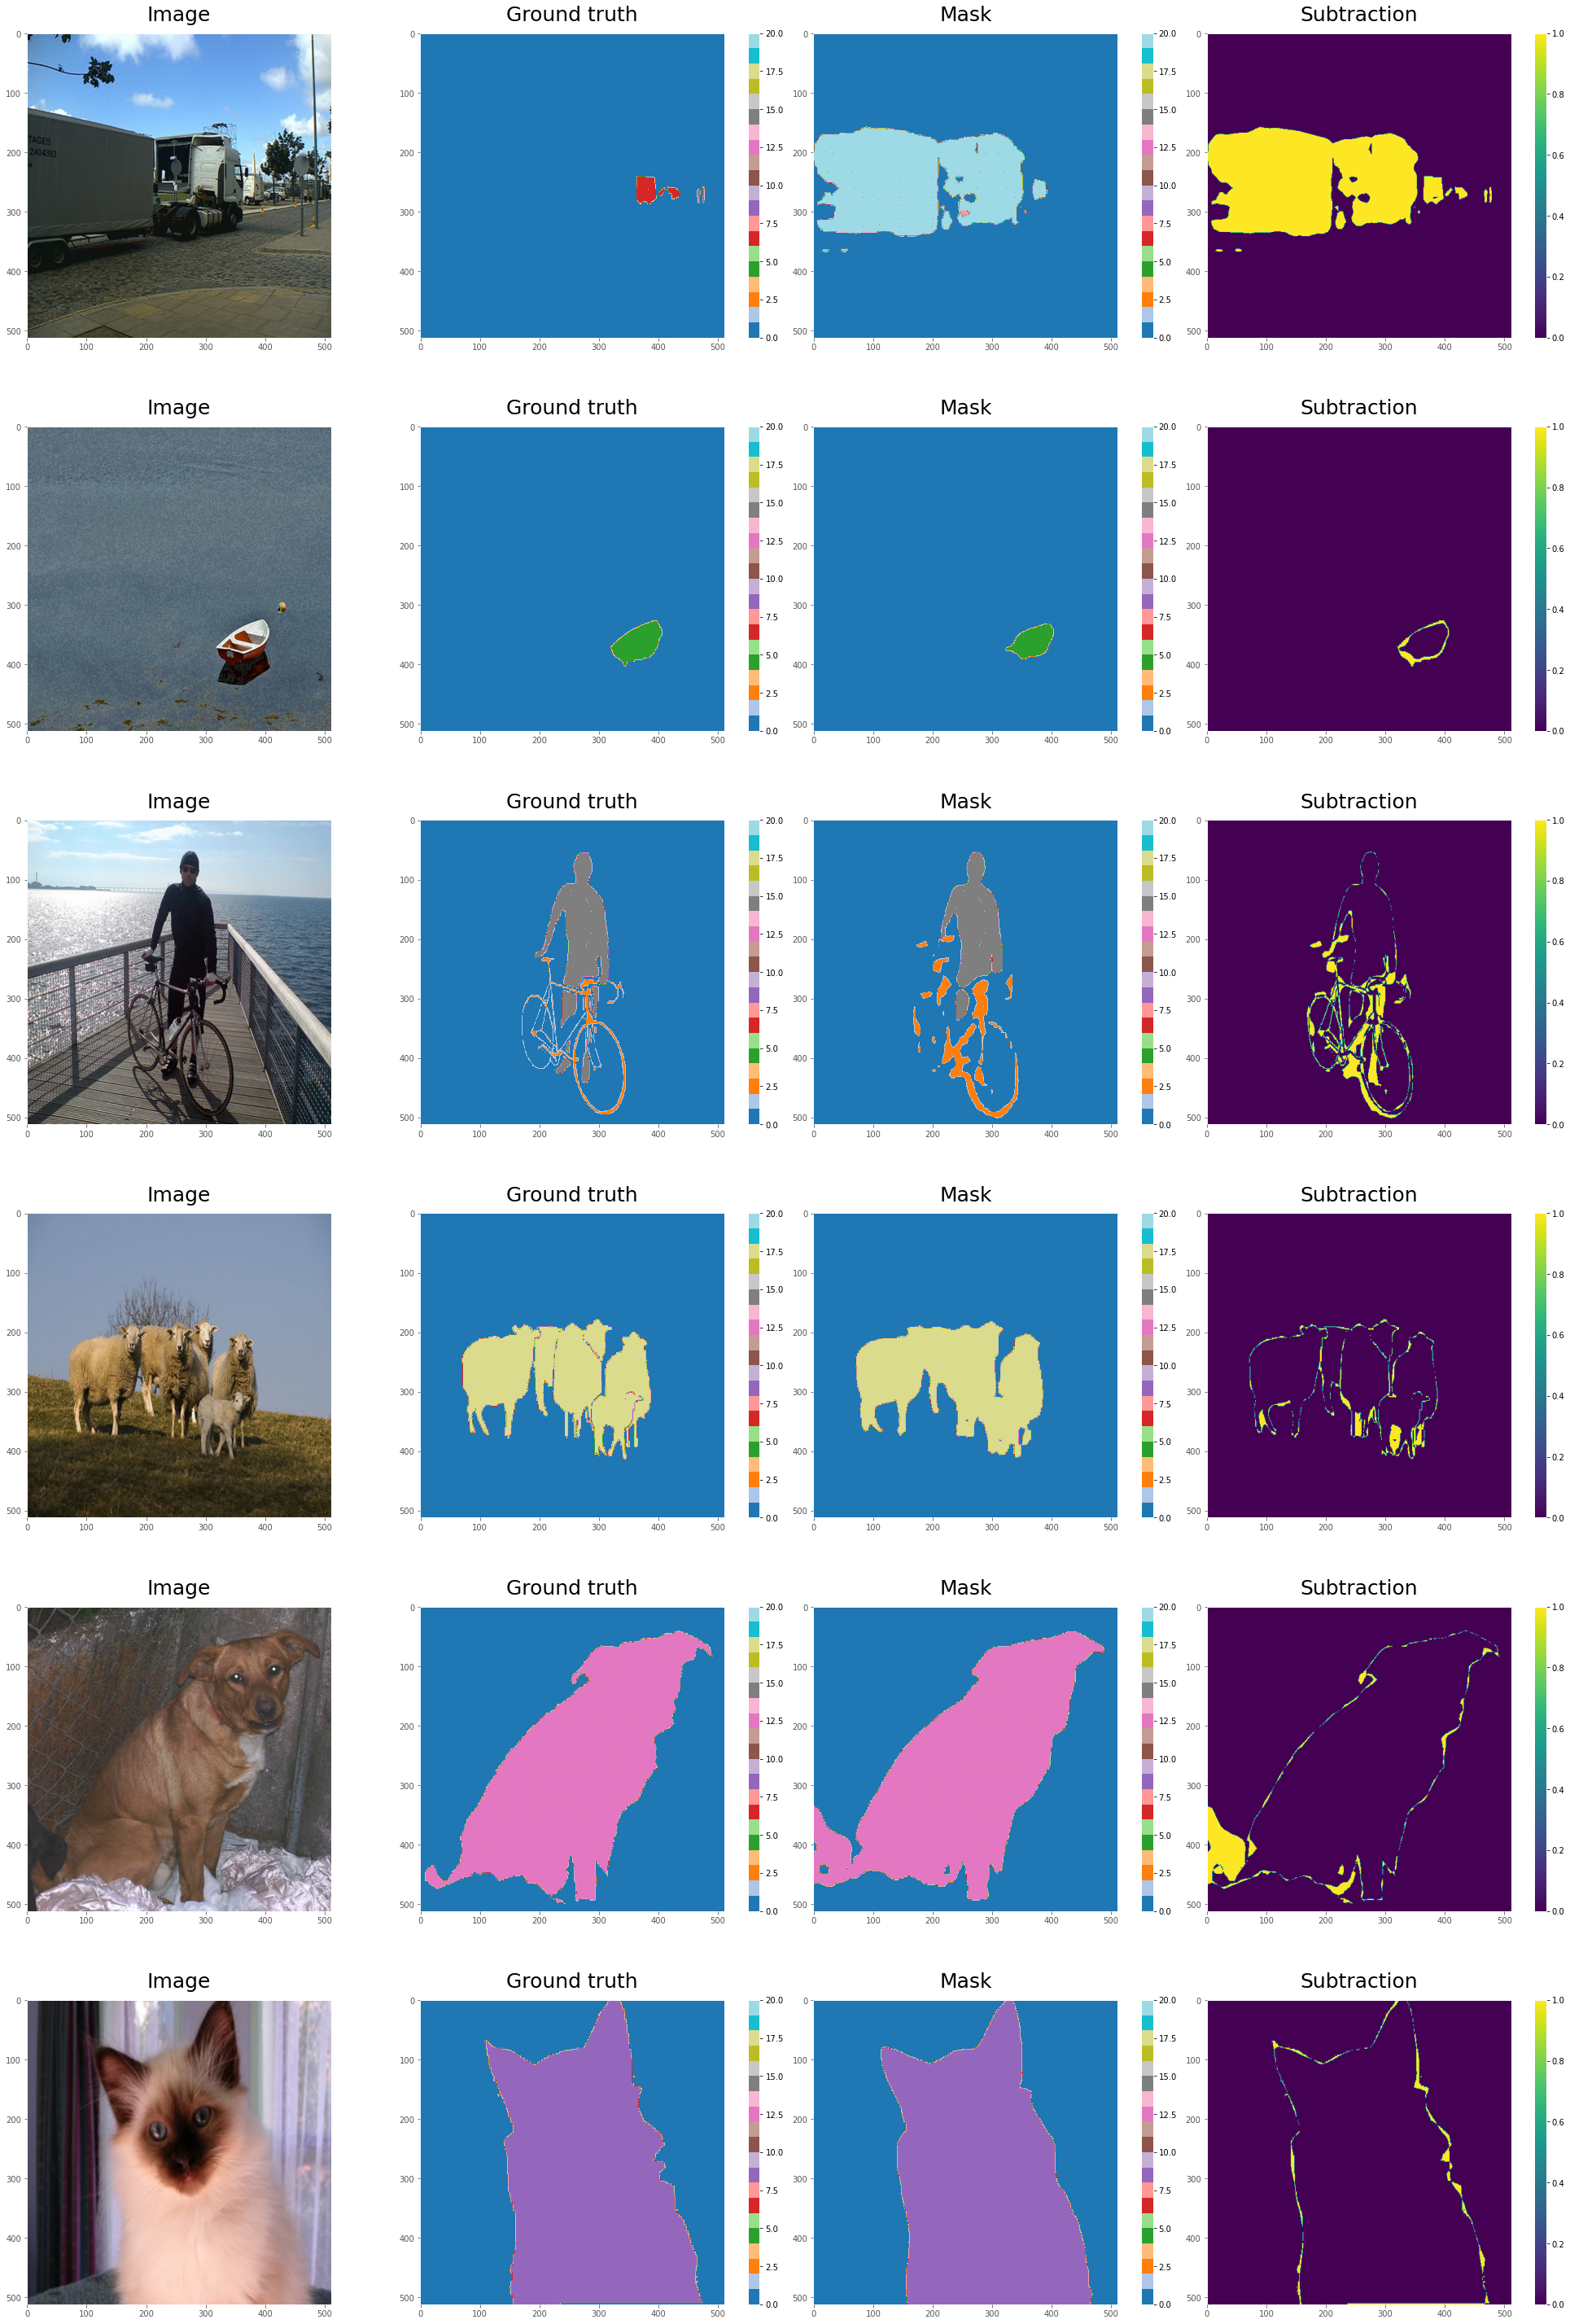

In [17]:
val_pipeline.reset('iter')
test_batch = val_pipeline.next_batch(6, shuffle=True)
images = test_batch.images
images = images.transpose((0, 2, 3, 1))
masks = test_batch.train_labels
predicted_masks = test_batch.predicted_masks.argmax(axis=1)
sub = predicted_masks - masks
sub[sub.nonzero()] = 1

all_images = []
num_images = len(images)

for imgs in zip(images, masks, predicted_masks, sub):
    all_images.extend(imgs)

plot(all_images,
     title=['Image', 'Ground truth', 'Mask', 'Subtraction'] * num_images,
     combine='separate',
     cmap=(['tab20'] * 3 + ['viridis']) * num_images,
     colorbar=[False, True, True, True] * num_images,
     ncols=4,
     vmin=0,
     vmax=([20] * 3 + [1]) * num_images)

Well, the masks are good enough.

We can also visualize the confusion matrix and get information about the model mismatches: 

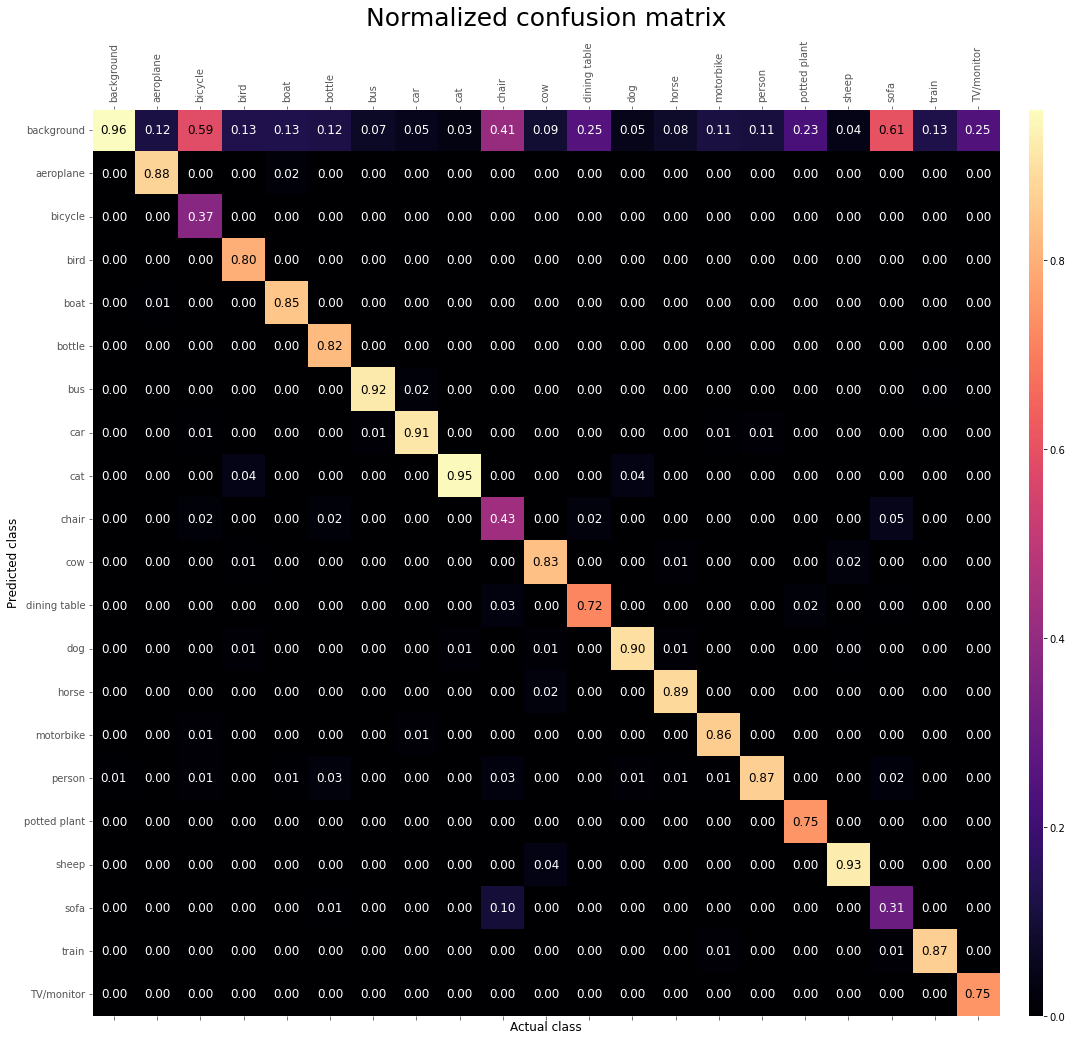

In [18]:
metrics = val_pipeline.v('metrics')
metrics.plot_confusion_matrix(classes=dataset.classes, normalize=True, figsize=(15, 15))

From the predicted masks and confusion matrix, we can conclude that model confuses some classes with the background more frequently, for example, bicycle. It's reasonable since a bicycle has few pixels compared to the background. Also, sometimes model finds other classes on the image even though they are not labeled on it. 

At a final point, let's check the quality of our code:

In [19]:
pylint_notebook()

Your code has been rated at 10.00/10 (previous run: 9.61/10, +0.39)
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


<a id='conclusion'></a>
## Conclusion

In this tutorial, we've learned how to solve the segmentation task with the Batchflow library.
You can try out to improve our solution and get better results. But before it, we highly recommend you to read our previous [tutorials](https://github.com/analysiscenter/batchflow/tree/master/examples) including the classification tutorial.